In [9]:
import tensorflow as tf
import keras
import requests
import cv2
import os
import numpy as np
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
class_indices = {0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'Tomato___Leaf_Mold', 32: 'Tomato___Septoria_leaf_spot', 33: 'Tomato___Spider_mites Two-spotted_spider_mite', 34: 'Tomato___Target_Spot', 35: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 36: 'Tomato___Tomato_mosaic_virus', 37: 'Tomato___healthy'}

In [21]:
curr_w_dir = os.getcwd()
img_base='rice-disease.png'
img_path = os.path.join(curr_w_dir, img_base)

url = "https://upload.wikimedia.org/wikipedia/commons/9/9c/Cochliobolus_miyabeanus.jpg"
# Fetch the image from the URL
response = requests.get(url)

# Convert the image to a numpy array
image_array = np.frombuffer(response.content, np.uint8)

# Decode the image array to OpenCV format
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

image = cv2.resize(image,(256,256))
IMAGE_TEST = image
# # Now you can use the image with OpenCV functions
cv2.imwrite(img_path, image)

True

In [5]:
loaded_model_xception = keras.models.load_model('/Users/danielthorne/pdd-test/prediction-api/prediction-model/plant_disease_cnn_model_xception.h5')

In [6]:
# Function to preprocess a single image
def preprocess_image(image_path):
    image = skimage.io.imread(image_path)
    image_array = np.array(image) / 255.0  # Normalize to [0,1]
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

In [22]:
img_size = (256, 256)
predictions = loaded_model_xception.predict(preprocess_image(img_path))
print(predictions[0])
predicted_class = np.argmax( predictions, axis=1)[0]
top_5_predicted_class = np.argsort(predictions[0])[-5:][::-1]
predicted_class_explicit = [ class_indices[p_class] for p_class in top_5_predicted_class]
print(f" The list of potential classes are : ")
predicted_class_explicit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
[1.0692759e-02 2.1392647e-03 4.5212454e-04 8.6245464e-06 2.4731347e-05
 3.6993824e-05 1.8483317e-04 1.1815196e-03 9.0895034e-03 2.2900826e-03
 1.0774794e-05 6.6655442e-02 4.6459809e-05 8.7393644e-05 1.4975534e-05
 4.8566985e-04 7.4958706e-01 1.4920345e-04 2.0675436e-02 1.8227519e-04
 2.1478433e-04 3.9035297e-04 5.0985307e-04 1.8243815e-04 1.2867264e-05
 1.6081557e-04 1.3274738e-01 1.0907195e-04 2.5858812e-06 3.7848720e-05
 2.4833304e-05 5.0220924e-06 6.5494439e-04 2.1936997e-07 9.1870362e-04
 7.0113816e-07 3.2336204e-05 2.1527802e-07]
 The list of potential classes are : 


['Peach___Bacterial_spot',
 'Strawberry___Leaf_scorch',
 'Grape___Black_rot',
 'Pepper,_bell___Bacterial_spot',
 'Apple___Apple_scab']

<Functional name=functional_3, built=True>
tf.Tensor(16, shape=(), dtype=int64)


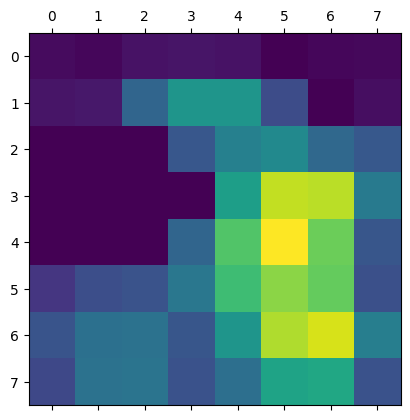

In [23]:

model = loaded_model_xception
# inputs = model.inputs
# outputs = model(inputs)
# redefined_model = tf.keras.Model(inputs=inputs, outputs=outputs) 
grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer("block14_sepconv2_act").output, model.output]
)
print(grad_model)
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(preprocess_image(img_path))
    
    pred_index = tf.argmax(preds[0])
    print(pred_index)
    class_channel = preds[ : ,pred_index]
grads = tape.gradient(class_channel, last_conv_layer_output)
# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
plt.matshow(heatmap.numpy())
plt.show()

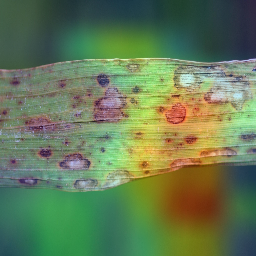

In [24]:
# Load the original image
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

alpha=0.4
curr_w_dir = os.getcwd()
img_base='overlays/rice-disease-overlay.png'
cam_path = os.path.join(curr_w_dir,img_base )

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save(cam_path)

# Display Grad CAM
display(Image(cam_path))